In [1]:
%matplotlib notebook

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpt
from copy import deepcopy as cp
from matplotlib.widgets import Slider, Button, RadioButtons
from lmfit import Parameters

def gaussian_noise(x,a,m,s):
    #return((a/np.sqrt(2*3.14159)/s * np.exp(-0.5 * (x-m) * (x-m) / s**2) )+200+.1*np.random.randn(len(x)))
    return((a * np.exp(-0.5 * (x-m) * (x-m) / s**2) )+200+np.random.randn(len(x)))

def linear_cusp(x,a,b,m):
    retvec = np.zeros(len(x))
    midp = len(x)/2
    retvec[int(midp+m):] += a*(x[int(midp+m):]-m) + b 
    return(retvec+np.random.randn(len(x)))

def square_pulse(x,a,m,s):
    midp = len(x)/2
    retvec = cp(x)
    retvec*=0
    retvec[int(midp+m-s/2):int(midp+m+s/2)]=a
    return(retvec+np.random.randn(len(x)))

def square_wave(x,a,m,s,g):
    midp = len(x)/2
    retvec = cp(x)
    retvec*=0
    retvec[int(midp+m-s/2):int(midp+m+s/2)]=a
    retvec[int(midp+g+m-s/2):int(midp+g+m+s/2)]=-2*a
    return(retvec+np.random.randn(len(x)))

def triangle_pulse(x,a,w,m):
    retvec = np.zeros(len(x))
    midp = len(x)/2
    d = a*2/w
    retvec[int(midp+m-w/2):int(midp+m)] += d*(x[int(midp+m-w/2):int(midp+m)] - m - x[midp] +w/2)  
    retvec[int(midp+m):int(midp+m+w/2)] += -d*(x[int(midp+m):int(midp+m+w/2)] - m - x[midp]) + a 
    return(retvec+np.random.randn(len(x)))

def triangle_wave(x,a,w,m,s):
    retvec = np.zeros(len(x))
    midp = len(x)/2
    d = a*2/w
    retvec[int(midp+m-w/2):int(midp+m)] += d*(x[int(midp+m-w/2):int(midp+m)] - m - x[midp] +w/2)  
    retvec[int(midp+m):int(midp+m+w/2)] += -d*(x[int(midp+m):int(midp+m+w/2)] - m - x[midp]) + a 
    retvec[int(midp+m+w/2+s):int(midp+m+s+w)] += -d*(x[int(midp+m-w/2):int(midp+m)] - m - x[midp] +w/2)  
    retvec[int(midp+m+s+w):int(midp+m+3*w/2+s)] +=  d*(x[int(midp+m):int(midp+m+w/2)] - m - x[midp]) - a 
    return(retvec+np.random.randn(len(x)))

def vandle_pulse(x,a,m,r,f):
    retvec = np.zeros(len(x))
    midp = int(len(x)/2+m)
    retvec[midp:]= a**2/(f-r)*(np.exp(-(x[midp:]-m)/f)-np.exp(-(x[midp:]-m)/r)) 
    retvec += np.random.randn(len(x)) 
    return( retvec )
        
def trap_filter(times,res,L,G):
    retvec = np.zeros(len(res))
    zidx = times.searchsorted(0)
    for i in range(zidx,len(times)):
      retvec[times.searchsorted(times[i])]=(res[i-L+1:i]-res[i-2*L-G+1:i-L-G]).sum()
    return(retvec)
    
def tau_adjust(pulse,tau):
    bls = cp(pulse)
    retvec = cp(pulse)
    bls -= pulse[:1000].mean()
    for t in range(3,len(pulse)):
        pz = bls[:t-1].sum()
        retvec[t] += bls[t] + pz/tau 
    return(retvec)

def zero_crossing(trap):
    delay = cp(trap)
    td = 20
    cf = .8
    delay[:-td] += -cf*trap[td:] 
    return(delay)
    
def fxn(x,f_name,params):
    """
    generic function wrapper. inputs are model name string and dictionary of variables.
    """   
    if f_name == "gaussian_noise":
        if all( i in params.keys() for i in ('amp','mean','sigma')):
            return(
                gaussian_noise(x,params['amp'].value,params['mean'].value,params['sigma'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "linear_cusp":
        if all( i in params.keys() for i in ('slope','offset','start')):
            return(
                linear_cusp(x,params['slope'].value,params['offset'].value,params['start'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "square_pulse":
        if all( i in params.keys() for i in ('amp','mean','sigma')):
            return(
                square_pulse(x,params['amp'].value,params['mean'].value,params['sigma'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "square_wave":
        if all( i in params.keys() for i in ('amp','mean','sigma','spacing')):
            return(
                square_wave(x,params['amp'].value,params['mean'].value,params['sigma'].value,params['spacing'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "triangle_pulse":
        if all( i in params.keys() for i in ('amp','width','mean')):
            return(
                triangle_pulse(x,params['amp'].value,params['width'].value,params['mean'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "triangle_wave":
        if all( i in params.keys() for i in ('amp','width','mean','spacing')):
            return(
                triangle_wave(x,params['amp'].value,params['width'].value,params['mean'].value,params['spacing'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)
    elif f_name == "vandle_pulse":
        if all( i in params.keys() for i in ('amp','mean','rise','fall')):
            return(
                vandle_pulse(x,params['amp'].value,params['mean'].value,params['rise'].value,params['fall'].value)
            )
        else:
            print("Parameters mismatched to model or not found")
            return(False)

    else:
        print("Model not implemented or not found")
        return(False)
        
t = np.arange(-2000,2000,1)
l0=100
g0=200
t0 = 20
norm = 1 #np.sqrt(2*3.14159)*s0
margin = 2

Select Model:

In [11]:
#model = "gaussian_noise"
#model = "vandle_pulse"
#model = "linear_cusp"
model = "square_pulse"
#model = "square_wave"
#model = "triangle_pulse"
#model = "triangle_wave"

<IPython.core.display.Javascript object>


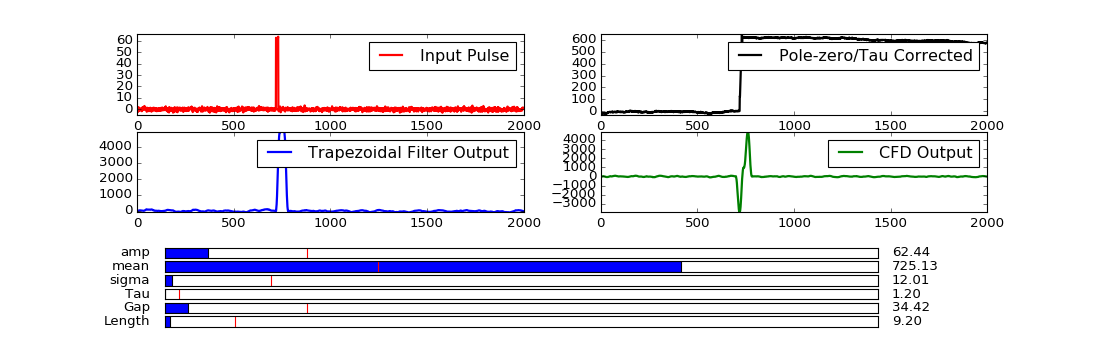

0

In [12]:
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2,sharex=ax1)
ax3 = plt.subplot(3,2,3,sharex=ax1)
ax4 = plt.subplot(3,2,4,sharex=ax1)

fig = plt.figure(1)

variables = Parameters()

if model == "gaussian_noise":
    variables.add_many(('amp',200,True,1,1000,None),
           ('mean',300,True,1,1000,None),
           ('sigma',150,True,1,1000,None))
elif model == "square_pulse":
    variables.add_many(('amp',200,True,1,1000,None),
           ('mean',300,True,1,1000,None),
           ('sigma',150,True,1,1000,None))
elif model == "square_wave":
    variables.add_many(('amp',200,True,1,1000,None),
           ('mean',300,True,1,1000,None),
           ('sigma',150,True,1,1000,None),
           ('spacing',150,True,1,1000,None))
elif model == "triangle_pulse":
    variables.add_many(('amp',200,True,1,1000,None),
           ('width',300,True,1,1000,None),
           ('mean',200,True,1,1000,None))
elif model == "triangle_wave":
    variables.add_many(('amp',200,True,1,1000,None),
           ('width',300,True,1,1000,None),
           ('mean',200,True,1,1000,None),
           ('spacing',150,True,1,1000,None))
elif model == "linear_cusp":
    variables.add_many(('slope',1,True,-20,20,None),
           ('offset',300,True,1,1000,None),
           ('start',150,True,1,1000,None))
elif model == "vandle_pulse":
    variables.add_many(('amp',50,True,.01,100,None),
           ('mean',200,True,1,1000,None),
           ('rise',10,True,.1,200,None),
           ('fall',150,True,.1,200,None))  
             
pulse = fxn(t,model,variables) #gaussian_noise(t,a0*norm,m0,s0)
pz = tau_adjust(pulse,t0)
ff = trap_filter(t,pz/norm,l0,g0)
zc = zero_crossing(ff)

l,= ax1.plot(t,pulse,lw=2,color='red')
ax1.legend(['Input Pulse'])
l2,= ax2.plot(t,pz,lw=2,color='k')
ax2.legend(['Pole-zero/Tau Corrected'])
l3,= ax3.plot(t,ff,lw=2,color='blue')
ax3.legend(['Trapezoidal Filter Output'])
l4,= ax4.plot(t,zc,lw=2,color='green')
ax4.legend(['CFD Output'])
#l5,= ax4.plot(t[20:],zc[1],lw=2,color='purple')
ax2.set_xlim(0,2000)
#ax1.set_ylim(pulse.min()-margin,pulse.max()+margin)
#ax2.set_ylim(ff.min()-margin,ff.max()+margin)
#plt.axis([0,2000,-100,100])
#ax1.autoscale(axis='y')
#ax2.autoscale(axis='y')

axDict = dict()
key_len = len(variables.keys())
for k in variables.keys():
    axDict[k] = plt.axes([0.15, key_len*0.04 + 0.13,0.65, 0.03])
    key_len -= 1
    
#axamp = plt.axes([0.15,0.05, 0.65, 0.03])
#axmean = plt.axes([0.15,0.09, 0.65, 0.03])
#axsigma = plt.axes([0.15,0.13, 0.65, 0.03])

axlen = plt.axes([0.15,0.05, 0.65, 0.03])
axgap = plt.axes([0.15,0.09, 0.65, 0.03])
axtau = plt.axes([0.15,0.13, 0.65, 0.03])
slideDict = dict()
key_len = len(variables.keys())
for k in variables.keys():
    slideDict[k] = Slider(axDict[k], k , variables[k].min, variables[k].max, valinit=variables[k].value)
    

    
#samp = Slider(axamp, 'Amp', 1, 500, valinit=variables['amp'].value)
#smean = Slider(axmean, 'Mean', 1, 1000.0, valinit=variables['mean'].value)
#ssigma = Slider(axsigma, 'Sigma', 1, 1000.0, valinit=variables['sigma'].value)
slen = Slider(axlen, 'Length', 1, 1000.0, valinit=l0)
sgap = Slider(axgap, 'Gap', 1, 1000.0, valinit=g0)
stau = Slider(axtau, 'Tau', .001, 1000.0, valinit=t0)

def update(val):
    for k in variables.keys():
        variables[k].value = slideDict[k].val
      
#    variables['sigma'].value = ssigma.val
#    variables['amp'].value = samp.val
    slen.val = round(slen.val)
    length = slen.val
    sgap.val = round(sgap.val)
    gap = sgap.val
    tau = stau.val
    pulse = fxn(t,model,variables)#gaussian_noise(t,amp*norm,mean,sigma)
    pz = tau_adjust(pulse,tau)
    ff = trap_filter(t,pz/norm,length,gap)
    zc = zero_crossing(ff)
    l.set_ydata( pulse )
    l2.set_ydata( pz )
    l3.set_ydata( ff )
    l4.set_ydata( zc )
    ax1.set_ylim(pulse.min()-margin,pulse.max()+margin)
    ax2.set_ylim(pz.min()-margin,pz.max()+margin)
    ax3.set_ylim(ff.min()-margin,ff.max()+margin)
    ax4.set_ylim(zc.min()-margin,zc.max()+margin)
    fig.canvas.draw_idle()

for k in variables.keys():    
    slideDict[k].on_changed(update)
    
#smean.on_changed(update)
#ssigma.on_changed(update)
slen.on_changed(update)
sgap.on_changed(update)
stau.on_changed(update)